In [2]:
!pip install pytorch-lightning

In [3]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [ ]:
wandb.login()

In [4]:
import numpy as np
import pandas as pd 
import pytorch_lightning as L
from torchvision import transforms, models,datasets
import cv2
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import Dataset, DataLoader ,random_split,Subset
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torch.optim as optim 
from torchmetrics import MetricCollection, Accuracy
import torch.nn.functional as F
import torch
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import wandb
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision

In [99]:
!python train_cnn.py -p /kaggle/input/neurolist/inaturalist_12K -e 1

2024-04-05 20:19:32.149093: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 20:19:32.149158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 20:19:32.150897: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Sanity Checking DataLoader 0: 100%|███████████████| 2/2 [00:00<00:00,  3.06it/s]/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/opt/conda/lib/

In [5]:
class root_dataset(Dataset):
    def __init__(self):
        self.dataset1=datasets.ImageFolder(root='/kaggle/input/neurolist/inaturalist_12K/train')
        l1=int(len(self.dataset1)*0.8)
        train_dataset,val_dataset=random_split(self.dataset1, [int(len(self.dataset1)*0.8),len(self.dataset1)-l1])
        #print(len(train_dataset),len(val_dataset))
        self.train_dataset=train_dataset
        self.val_dataset=val_dataset
    def get_train_data(self):
        return self.train_dataset
    def get_val_data(self):
        return self.val_dataset

In [6]:
class inaturalist_train(Dataset):
    def __init__(self,train_data):
        self.target_size=(3,224,224)
        #dataset1=datasets.ImageFolder(root='/kaggle/input/neurolist/inaturalist_12K/train')
        self.dataset=train_data    
        self.transform = transforms.Compose([
            transforms.Resize(self.target_size[1:]),
            transforms.ToTensor()
        ])#self.target_size = target_size 
        
    def __getitem__(self,idx):
        image,label=self.dataset[idx]
        image=self.transform(image)
        return image,label
    def __len__(self):
        return len(self.dataset)

In [7]:
class inaturalist_val(Dataset):
    def __init__(self,val_data):
        self.target_size=(3,224,224)
        #dataset1=datasets.ImageFolder(root='/kaggle/input/neurolist/inaturalist_12K/train')
        self.dataset=val_data
        self.transform = transforms.Compose([
            transforms.Resize(self.target_size[1:]),
            transforms.ToTensor()
        ])#self.target_size = target_size   
    def __getitem__(self,idx):
        image,label=self.dataset[idx]
        image=self.transform(image)
        return image,label
    def __len__(self):
        return len(self.dataset)

In [8]:
class inaturalist_test(Dataset):
    def __init__(self):
        self.target_size=(3,224,224)
        self.dataset=datasets.ImageFolder(root='/kaggle/input/neurolist/inaturalist_12K/val')
        self.transform = transforms.Compose([
            transforms.Resize(self.target_size[1:]),  # Resize images to target size
            transforms.ToTensor()
        ])#self.target_size = target_size   
    def __getitem__(self,idx):
        image,label=self.dataset[idx]
        image=self.transform(image)
        return image,label
    def __len__(self):
        return len(self.dataset)

In [9]:
class Activation_Function:
    def activation_Function(self,activation_function):
        if activation_function=='relu':
            return F.relu
        if activation_function=='gelu':
            return F.gelu
        if activation_function=='selu':
            return F.selu
        if activation_function=='elu':
            return F.elu

In [10]:
class Lightning_CNN(L.LightningModule):
    def __init__(self,layers,kernel_size,pool_kernel,pool_stride,dense_layer_size,batch_normalization,drop_out,a_fun,optimizer,dense_layer_output,learning_rate):
        super().__init__()
        self.batch_normalization=batch_normalization
        self.drop_out=drop_out
        self.optimizer=optimizer
        act_object=Activation_Function()
        self.dense_layer_output=dense_layer_output
        self.act_fun=act_object.activation_Function(a_fun)
        self.learning_rate=learning_rate
        self.conv1 = nn.Conv2d(3,layers[0], kernel_size=kernel_size[0], padding=1)
        self.b1=nn.BatchNorm2d(layers[0])
        self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel[0], stride=pool_stride[0])
        self.conv2 = nn.Conv2d(layers[0],layers[1],kernel_size=kernel_size[1], padding=1)
        self.b2=nn.BatchNorm2d(layers[1])
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel[1], stride=pool_stride[1])
        self.conv3 = nn.Conv2d(layers[1],layers[2], kernel_size=kernel_size[2], padding=1)
        self.b3=nn.BatchNorm2d(layers[2])
        self.pool3 = nn.MaxPool2d(kernel_size=pool_kernel[2], stride=pool_stride[2])
        self.conv4 = nn.Conv2d(layers[2],layers[3], kernel_size=kernel_size[3], padding=1)
        self.b4=nn.BatchNorm2d(layers[3])
        self.pool4 = nn.MaxPool2d(kernel_size=pool_kernel[3], stride=pool_stride[3])
        self.conv5 = nn.Conv2d(layers[3],layers[4], kernel_size=kernel_size[4], padding=1)
        self.b5=nn.BatchNorm2d(layers[4])
        self.pool5 = nn.MaxPool2d(kernel_size=pool_kernel[4], stride=pool_stride[4])
        self.dropout = nn.Dropout(p=drop_out)
        self.fc1 = nn.Linear(dense_layer_size, self.dense_layer_output)
        self.fc2 = nn.Linear(self.dense_layer_output, 10)
    def forward(self,x):
        if self.batch_normalization==True:
            x=self.pool1(self.act_fun(self.b1(self.conv1(x))))
            x=self.pool2(self.act_fun(self.b2(self.conv2(x))))
            x=self.pool3(self.act_fun(self.b3(self.conv3(x))))
            x=self.pool4(self.act_fun(self.b4(self.conv4(x))))
            x=self.pool5(self.act_fun(self.b5(self.conv5(x))))
        else:
            x=self.pool1(self.act_fun(self.conv1(x)))
            x=self.pool2(self.act_fun(self.conv2(x)))
            x=self.pool3(self.act_fun(self.conv3(x)))
            x=self.pool4(self.act_fun(self.conv4(x)))
            x=self.pool5(self.act_fun(self.conv5(x)))

        x=self.dropout(x)
        x=torch.flatten(x,1)
        x=self.dropout(x)
        x=self.act_fun(self.fc1(x))
        x=self.fc2(x)
        return x
    def training_step(self, batch, batch_idx):
        inputs,labels=batch
        output=self(inputs)
        _,preds = torch.max(output, dim=1)
        loss=F.cross_entropy(output,labels)
        #train_acc = torch.mean(preds == labels)
        #print(pred.shape)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    def configure_optimizers(self):
        if self.optimizer=='adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
            return optimizer
        if self.optimizer=='nadam':
            optimizer = torch.optim.NAdam(self.parameters(), lr=self.learning_rate)
            return optimizer
        if self.optimizer=='sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
            return optimizer
        
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        val_loss = F.cross_entropy(y_pred, y)
        
        # Compute validation accuracy
        _, predicted = torch.max(y_pred, 1)
        val_acc = torch.sum(predicted == y).item() / y.size(0)
        
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', val_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x,y=batch
        pred=self(x)
        loss=F.cross_entropy(pred,y)
        _, predicted = torch.max(pred, 1)
        accuracy = torch.sum(predicted == y).item() / y.size(0)
        #print(predicted,accuracy)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {"test_loss": loss,"prediction":predicted}
     


In [30]:
def save_images_with_labels(images, true_labels, predicted_labels,label_class, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i in range(len(true_labels)):
        true_labels[i]=label_class[true_labels[i]]
        predicted_labels[i]=label_class[predicted_labels[i]]
    for i, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
        # Plot the image with labels
        plt.imshow(image.permute(1, 2, 0).numpy())  # Assuming image tensor is in CHW format
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')

        # Save the image with labels
        filename = os.path.join(output_dir, f"image_{i}.png")
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        #plt.close()  # Close the plot to avoid displaying it

        # Show the image if needed
        plt.show()
        plt.show()

In [101]:
def main():
    if 5==5:
        #config=wandb.config
        #wandb.run.name = 'bs-'+str(config.batch_size)+'-lr-'+ str(config.learning_rate)+'-ep-'+str(config.epochs)+ '-op-'+str(config.optimizer)+ '-dls-'+str(config.dense_layer_size)+ '-act-'+str(config.activation)+'-do-'+str(config.dropout)+'-bn-'+str(config.batch_normalization)+'-cs-'+','.join(str(x) for x in config.conv_attributes_channels)+'-ck'+','.join(str(x) for x in config.conv_attributes_kernel_size)+'-pk-'+','.join(str(x) for x in config.pool_attributes_kernel_size)+'-ps-'+','.join(str(x) for x in config.pool_attributes_stride)
        number_of_filter=[[256,128,64,32,16],[32,64,32,64,32],[32,32,32,32,32],[16,32,64,128,256],[64,64,64,64,64]]
        layers=number_of_filter[0]
        kernel_size_per_layer=[[3,3,5,7,9],[7,5,5,3,3],[11,7,5,3,3],[3,3,3,5,5],[3,3,3,3,3],[11,7,7,5,3],[3,5,7,9,11]]
        kernel_size=kernel_size_per_layer[0]
        pooling_kernel_size_per_layer=[[2,2,2,2,2],[2,2,2,1,1],[2,1,3,1,2],[3,3,3,2,2]]
        pool_kernel=pooling_kernel_size_per_layer[1]
        pooling_stride_size_per_layer=[[2,2,2,2,2],[2,2,2,1,1],[1,1,2,2,2],[1,2,1,2,1],[2,2,2,2,1]]
        pool_stride=pooling_stride_size_per_layer[1]
        batch_normalization=True
        drop_out=0.3
        activation_function='gelu'
        optimizer='adam'
        b_size=8
        dense_layer_output=256
        epoch=10
        learning_rate=0.0001
    #aug_bit=True
        i_d=224
        D=0
        for i in range(5):
            D = (i_d - kernel_size[i])+3
            D = (D - pool_kernel[i])//pool_stride[i] + 1
            i_d = D
        root_obj=root_dataset()
        train_data=root_obj.get_train_data()
        val_data=root_obj.get_val_data()
        dataset1=inaturalist_train(train_data)
        dataset2=inaturalist_val(val_data)
        dataset3=inaturalist_test()
        test_dataloader=DataLoader(dataset=dataset3,batch_size=1,shuffle=True,num_workers=1)
        # im,lb=get_Random_samples(test_dataloader,31)
        # numpy_image = TF.to_pil_image(im.reshape(3,224,224))
    
        # Plot the numpy array as an image
        '''plt.imshow(numpy_image)
        plt.axis('off')
        plt.show()'''
        #print(im[0].shape)
        #print(len(dataset1))
    
        #print(len(dataset2))
        #wandb_logger = WandbLogger(project='amar_cs23m011', entity='Assignment2-CS6910')
        dataloader=DataLoader(dataset=dataset1,batch_size=b_size,shuffle=True,num_workers=2)
        val_dataloader=DataLoader(dataset=dataset2,batch_size=b_size,shuffle=False,num_workers=2)
        model=Lightning_CNN(layers,kernel_size,pool_kernel,pool_stride,(D**2)*layers[4],batch_normalization,drop_out,activation_function,optimizer,dense_layer_output,learning_rate)
        trainer = L.Trainer(accelerator='auto',devices="auto",max_epochs=epoch)
        trainer.fit(model,dataloader,val_dataloader)
        model.eval()
        true_label=[]
        pred_label=[]
        images=[]
        c=30
        for im,label in test_dataloader:
            if c==0:
                break;
            #print(c)
            with torch.no_grad():
                output = model(im)
            _, predicted_labels = torch.max(output, 1)
            true_label.append(label)
            pred_label.append(predicted_labels)
            images.append(im.squeeze(0))
            #print(type(im))
            c=c-1
# Process the output as needed (e.g., getting predicted labels)
        image1=torch.stack(images, dim=0)
        print(type(pred_label))
        print(type(true_label))
        print(image1.shape)
        c=0
        for i in range(30):
            if(pred_label[i]==true_label[i]):
                c=c+1
        print(c/30)
        #print(accuracy = torch.mean((pred_label == true_label).float()))
        #image_grid=torchvision.utils.make_grid(image1,3)
        #print(image_grid.shape)
        label_class=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Replilia']
        save_images_with_labels(image1, true_label, pred_label,label_class,'/kaggle/working/')
                
        test_dataloader=DataLoader(dataset=dataset3,batch_size=8,shuffle=False,num_workers=1)
        li=trainer.test(dataloaders=test_dataloader)
        #print(li[prediction])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

<class 'list'>
<class 'list'>
torch.Size([30, 3, 224, 224])
0.4


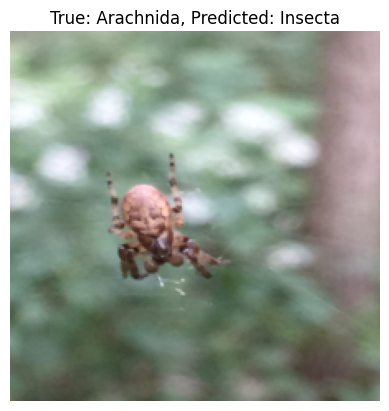

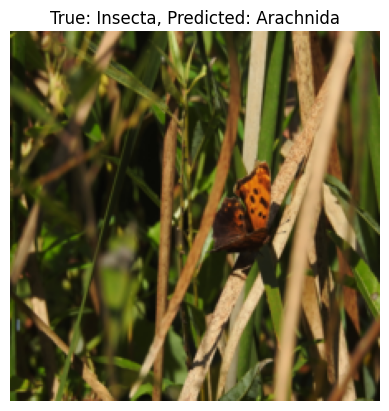

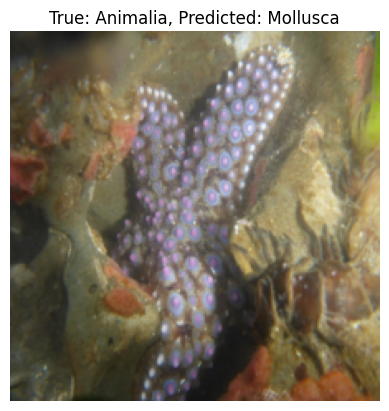

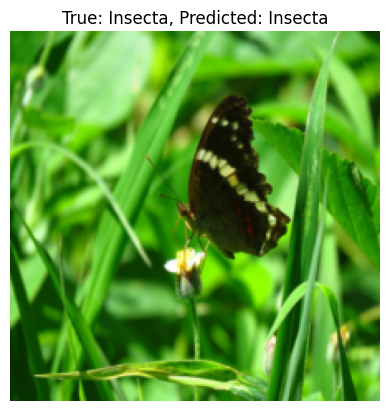

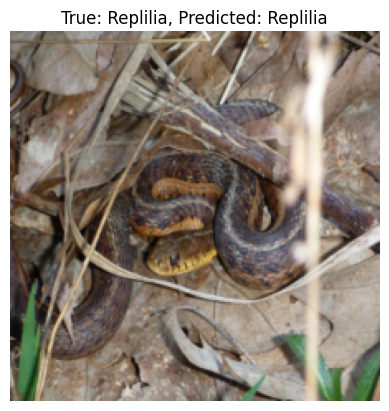

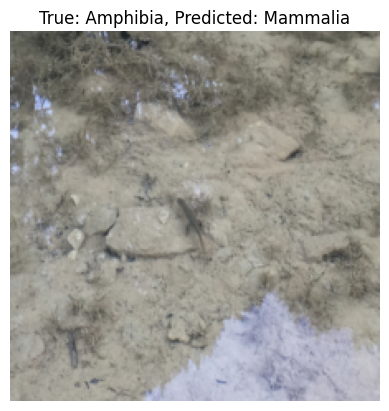

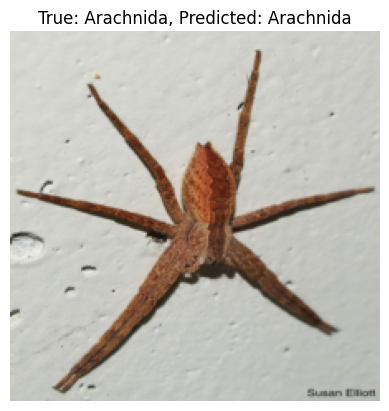

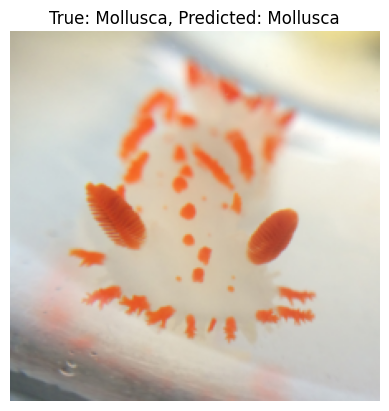

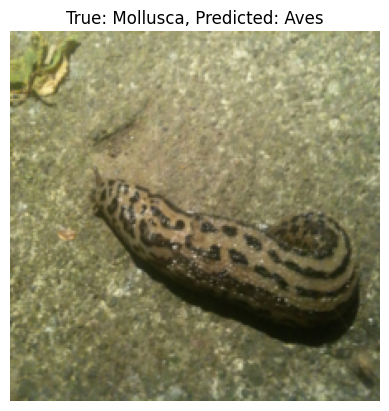

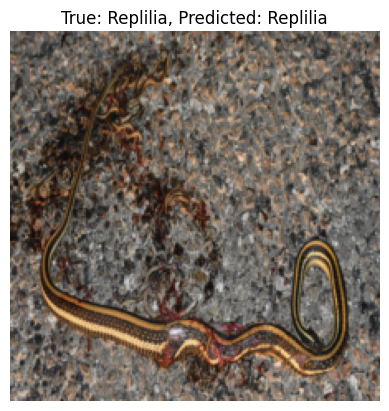

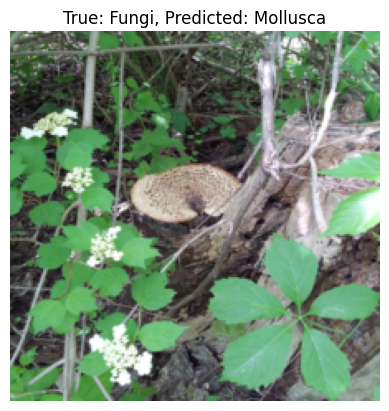

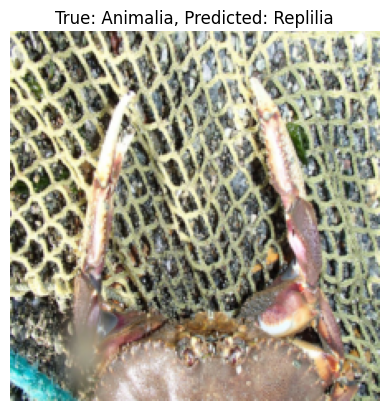

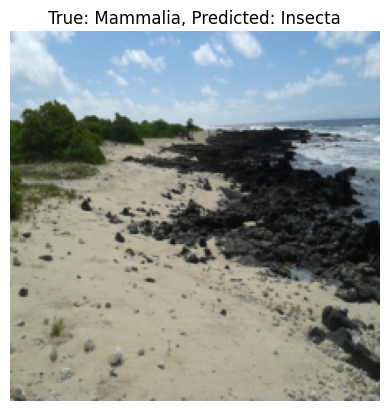

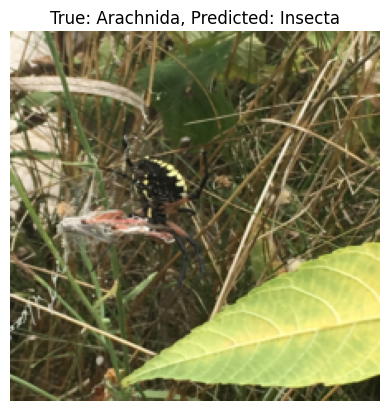

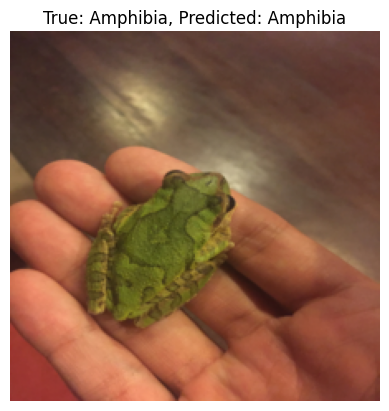

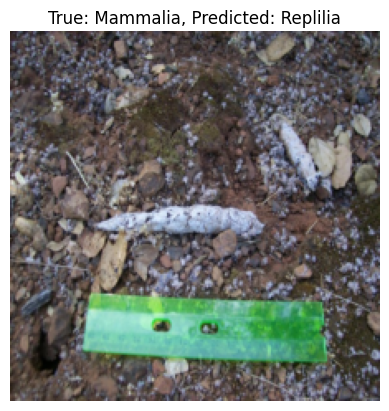

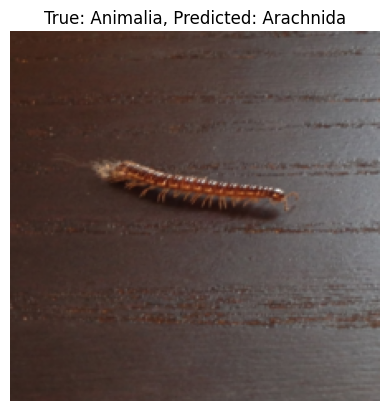

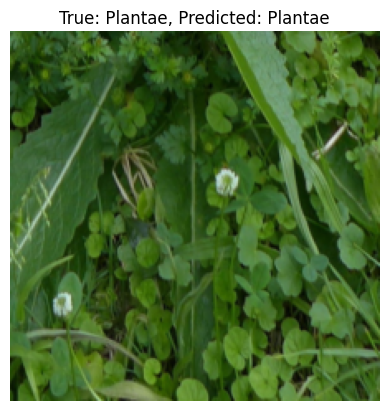

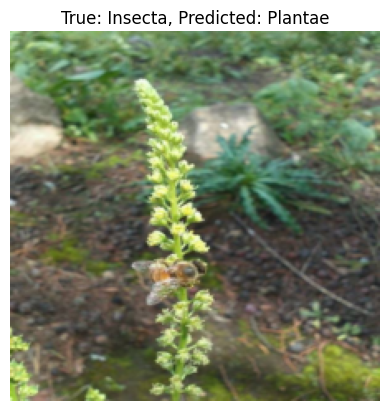

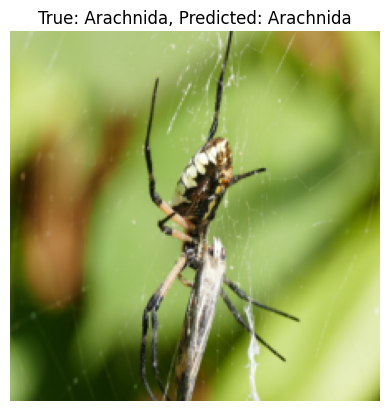

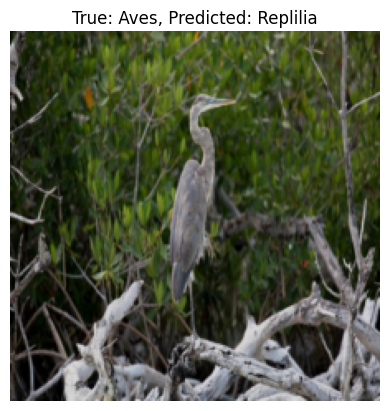

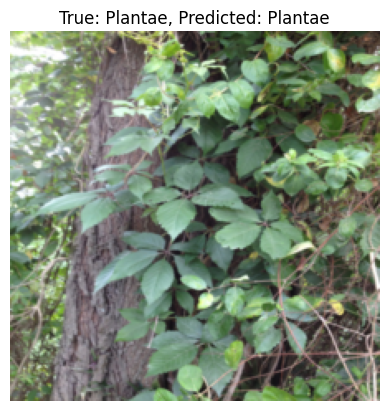

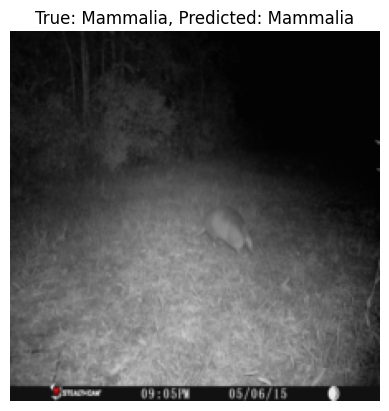

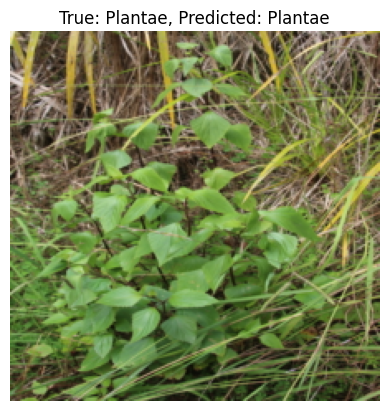

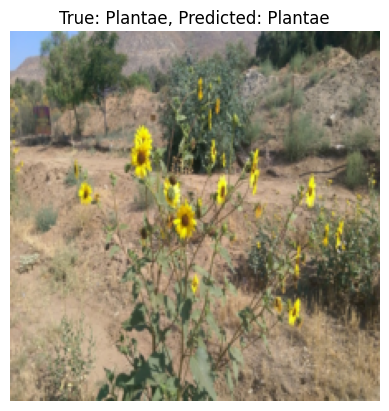

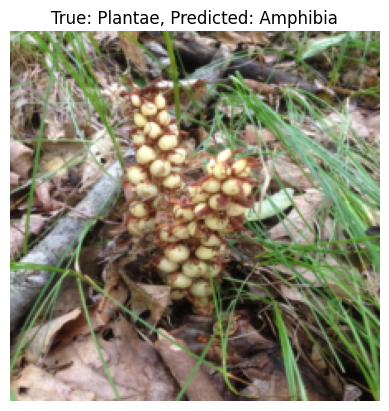

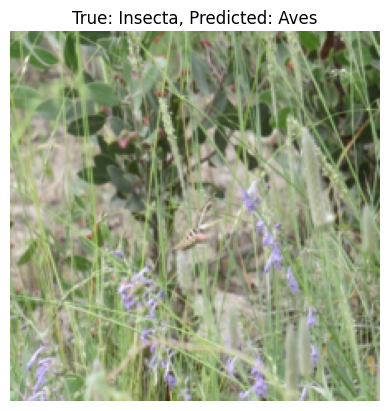

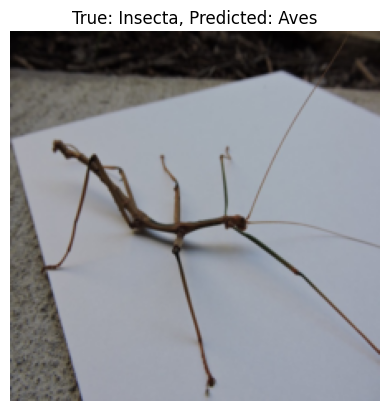

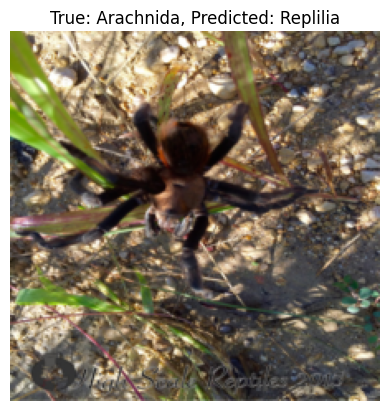

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.37049999833106995    │
│         test_loss         │    1.8514896631240845     │
└───────────────────────────┴───────────────────────────┘

In [102]:
if  __name__ =="__main__":
    #wandb.agent(sweep_id, main, count=60)
    main()
    